In [1]:
using SparseArrays, LinearAlgebra, Arpack,PyPlot , LsqFit

Auxiliary functions

In [2]:
function FlipSpins(x,i,j)
    f = typeof(x)(1)<<(i-1) | typeof(x)(1)<<(j-1) 
    return x ⊻ f
end

FlipSpins (generic function with 1 method)

The Hamiltonian from the recitation to compare ground state with

In [3]:
function ConstructHeisenbergHamiltonian(N)
    
    H = spzeros(2^N,2^N) # sparse matrix, will actually store only non-zero values, 
                         # i.e. no storage is allocated upon construction

    # Iterate over all the states in the basis |a> and calculate the nonzero matrix elements <b|H|a>
    # Recall that H = \sum_i H_{i,i+1}
    for a in range(0, length = 2^N)
        for i in range(1, length = N)
            j = mod(i,N)+1 # periodic boundary conditions
            si = ( a & 1<<(i-1) ) >> (i-1)
            sj = ( a & 1<<(j-1) ) >> (j-1)

            if si == sj
                H[a+1,a+1] += 1/4 # indexing in Julia is 1-based !!!
            else
                H[a+1,a+1] += - 1/4
                b = FlipSpins(a,i,j)
                H[a+1,b+1] = 1/2
            end
        end
    end
    
    return H
end

ConstructHeisenbergHamiltonian (generic function with 1 method)

# (0) warmup

Using:
$$
H=J\sum_{\langle ij \rangle} \vec{S_i}\cdot \vec{S_j} = J\sum_{\langle ij \rangle} [S_i^z S_j^z+1/2(S_i^+S_j^-+ S_i^-S_j^+)]
$$

In [4]:
function Hψ(ψ,J=1,shift=0)
    D=length(ψ)
    N_qubits=UInt(log2(D))
    new_ψ=zeros(D)
    for a in range(0,length=D)
        for j in range(1,length= N_qubits)
            j′= j%N_qubits+1
            sj = ( a & 1<<(j-1) ) >> (j-1)
            sj′= ( a & 1<<(j′-1) ) >> (j′-1)
            if sj==sj′
                new_ψ[a+1]+=J*ψ[a+1]/4
            else
                new_ψ[a+1]-=J*ψ[a+1]/4
                a_flipped=FlipSpins(a,j,j′)
                new_ψ[a_flipped+1]+=ψ[a+1]*J/2
            end
        end
    end
    return new_ψ+shift*ψ
end

Hψ (generic function with 3 methods)

In [5]:
function ψHψ(ψ,J=1,shift=0)
    H_ψ=Hψ(ψ,J,shift)
    return ψ⋅H_ψ/(ψ⋅ψ)
end

ψHψ (generic function with 3 methods)

In [6]:
function Hψ(ψ,J=1)
    D=length(ψ)
    N_qubits=UInt(log2(D))
    new_ψ=zeros(D)
    for a in range(0,length=D)
        for j in range(1,length= N_qubits)
            j′= j%N_qubits+1
            sj = ( a & 1<<(j-1) ) >> (j-1)
            sj′= ( a & 1<<(j′-1) ) >> (j′-1)
            if sj==sj′
                new_ψ[a+1]+=J*ψ[a+1]/4
            else
                new_ψ[a+1]-=J*ψ[a+1]/4
                a_flipped=FlipSpins(a,j,j′)
                new_ψ[a_flipped+1]+=ψ[a+1]*J/2
            end
        end
    end
    return new_ψ
end

Hψ (generic function with 3 methods)

In [7]:
function normalize_state!(ψ)
    ψ./=sqrt(sum(ψ.^2))
end

normalize_state! (generic function with 1 method)

In [8]:
iterations=100
N=12
ψ_arr=Vector{Vector{Any}}()
random_ψ=rand(2^N)
normalize!(random_ψ)
push!(ψ_arr,random_ψ)
for i in range(1,iterations)
    new_ψ=Hψ(last(ψ_arr))
    normalize!(new_ψ)
    push!(ψ_arr,new_ψ)
end

In [9]:
ground_energy_arr=Vector{Any}()
for vec in ψ_arr
    push!(ground_energy_arr,ψHψ(vec))
end

# Using the hamiltonian from the recitations to compare ground energy with

In [10]:
H = ConstructHeisenbergHamiltonian(N);

In [11]:
En = eigvals(Matrix(H));
println("Ground state energy is ", En[1])

Ground state energy is -5.387390917445211


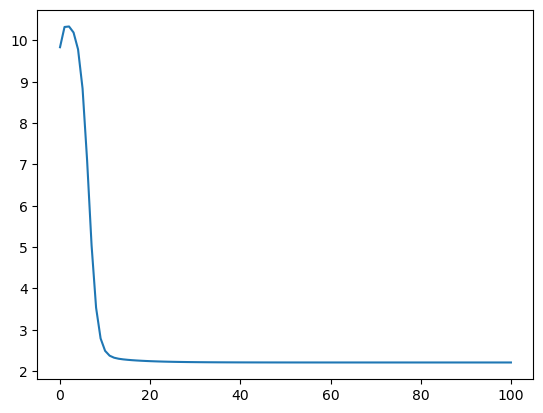

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4fd6a1c4f0>

In [20]:
plot(ground_energy_arr.-En[1])

# (1)

In [21]:
struct FixedSzBasis
    N::Int64
    Nup::Int64
    states::Vector{Int64}
    
    function FixedSzBasis(N::Int, Nup::Int)

        Ndown = N - Nup

        D = binomial(N, Nup)
        
        println("Dimension of subspace with S^z=", (Nup-Ndown)/2, " is ", D)

        states = zeros(Int, D)

        k=1
        for a in range(0, length = 2^N) # loop over all basis states
            if count_ones(a) == Nup
                states[k] = a
                k += 1
            end
        end
        
        new(N, Nup, states)
    end
    
end

import Base.length
function length(b::FixedSzBasis)
    return length(b.states)
end

function Sz(b::FixedSzBasis)
    Ndown = b.N - b.Nup
    return (b.Nup-Ndown)/2
end

Sz (generic function with 1 method)

In [22]:
function ConstructHeisenbergHamiltonian_generalized(basis::FixedSzBasis,J=1,couple_distance=1)
    
    D = length(basis)
    
    H = spzeros(D,D)
    
    # Iterate over all the states in the basis |a> and calculate the nonzero matrix elements <b|H|a>
    # Recall that H = \sum_i H_{i,i+1}
    for k in range(1, length = D)
        
        a = basis.states[k]

        for i in range(1, length = basis.N)
            j = mod(i-1+couple_distance,basis.N)+1 # periodic boundary conditions
            si = ( a & 1<<(i-1) ) >> (i-1)
            sj = ( a & 1<<(j-1) ) >> (j-1)

            if si == sj
                H[k,k] += J/4
            else
                H[k,k] += - J/4
                b = FlipSpins(a,i,j)
                l = searchsortedfirst(basis.states,b)
                @assert (l<=D) && (basis.states[l] == b) "Invalid basis state generated by FlipSpins"
                H[k,l] = J/2
            end
        end
    end
    
    return H
end

ConstructHeisenbergHamiltonian_generalized (generic function with 3 methods)

In [47]:
function generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,Sz_basis)
    H1=ConstructHeisenbergHamiltonian_generalized(Sz_basis,J1,1)
    H2=ConstructHeisenbergHamiltonian_generalized(Sz_basis,J2,2)
    return H1+H2
end

generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis (generic function with 1 method)

In [44]:
N, Nup = 18,9
basis = FixedSzBasis(N,Nup);
J1=0
J2=1
@time H = generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,basis);

Dimension of subspace with S^z=0.0 is 48620
 12.935257 seconds (39 allocations: 19.380 MiB)


In [45]:
@time res = eigs(H; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
En = res[1]
println("Ground state energy is ", En[1])

  1.256705 seconds (3.38 k allocations: 9.766 MiB)
Ground state energy is -7.594599567874035


# (2)

In [78]:
gc=0.241
g_arr=[0, gc, 0.48 ,1/2, 1, 2, 5]
J1=1
J2_arr=g_arr.*J1

7-element Vector{Float64}:
 0.0
 0.241
 0.48
 0.5
 1.0
 2.0
 5.0

In [79]:
Ns = 6:2:18
Egs_sz0=zeros(length(Ns),length(J2_arr))
Ees_sz0=zeros(length(Ns),length(J2_arr))
Egs_sz1=zeros(length(Ns),length(J2_arr))

for (i,N) in enumerate(Ns)
    Nup = Int(N/2)
    basis_sz0 = FixedSzBasis(N,Nup);
    for (j,J2) in enumerate(J2_arr)
        @time Heff = generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,basis_sz0)
        res = eigs(Heff; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
        En = sort(res[1])    
        Egs_sz0[i,j] = En[1]
        Ees_sz0[i,j] = En[2]
    end
    basis_sz1 = FixedSzBasis(N,Nup+1);
    for (j,J2) in enumerate(J2_arr)
        @time Heff = generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,basis_sz1)
        res = eigs(Heff; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
        En = sort(res[1])
        Egs_sz1[i,j] = En[1]
    end
end

Dimension of subspace with S^z=0.0 is 20
  0.000031 seconds (18 allocations: 6.391 KiB)
  0.000160 seconds (24 allocations: 11.422 KiB)
  0.000123 seconds (24 allocations: 11.422 KiB)
  0.000178 seconds (24 allocations: 11.422 KiB)
  0.000066 seconds (24 allocations: 11.422 KiB)
  0.000189 seconds (24 allocations: 11.422 KiB)
  0.000139 seconds (24 allocations: 11.422 KiB)
Dimension of subspace with S^z=1.0 is 15
  0.000073 seconds (19 allocations: 5.797 KiB)
  0.000029 seconds (25 allocations: 10.578 KiB)
  0.000079 seconds (25 allocations: 10.578 KiB)
  0.000169 seconds (25 allocations: 10.578 KiB)
  0.000146 seconds (25 allocations: 10.578 KiB)
  0.000121 seconds (25 allocations: 10.578 KiB)
  0.000077 seconds (25 allocations: 10.578 KiB)
Dimension of subspace with S^z=0.0 is 70
  0.000220 seconds (20 allocations: 23.469 KiB)
  0.000317 seconds (28 allocations: 44.562 KiB)
  0.000233 seconds (28 allocations: 44.562 KiB)
  0.000176 seconds (28 allocations: 44.562 KiB)
  0.000187 seco

Checking gaplessness

g=0

In [80]:
x = 1 ./ Ns
y = Egs_sz1[:,1]-Egs_sz0[:,1]

fun(x, a) = a[1] .+ a[2]*x
res = LsqFit.curve_fit(fun, x, y, [0., 0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.021734853049222645, 3.992425519564694], [0.0023974573279049727, -0.0018863020977822886, -0.002261602747670066, -0.0014105340231570507, -0.00019760512172101174, 0.0010717657716760032, 0.002286820912231674], [1.0000000000052196 0.16666666666611413; 0.9999999999960525 0.12500000000015962; … ; 1.000000000000636 0.06250000000007981; 1.000000000000636 0.05555555555594541], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

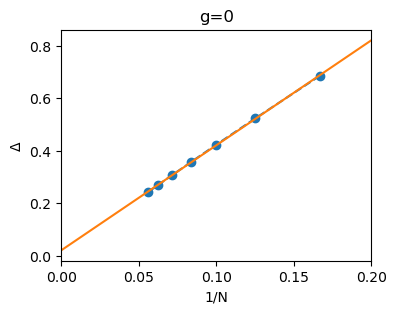

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4fd2855c90>

In [81]:
figure(figsize=(4,3))
plot(x, y, "o--")
xlim(0, 0.2)
title("g=0")
xlabel("1/N")
ylabel(L"\Delta");

x1 = 0:0.001:0.2
plot(x1, fun(x1, coef(res)))

In [82]:
x = 1 ./ Ns
y = Egs_sz1[:,2]-Egs_sz0[:,2]

fun(x, a) = a[1] .+ a[2]*x
res = LsqFit.curve_fit(fun, x, y, [0., 0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([-0.00969436048606643, 3.8440224013259168], [-0.002193463345880775, 0.0019967366051718005, 0.0019043147984096898, 0.0009821887334954815, -2.2568369859421455e-5, -0.000936737823475392, -0.001730470575458859], [1.0000000000052196 0.16666666666370247; 1.000000000000636 0.12499999999896923; … ; 1.000000000000636 0.062499999999484614; 1.000000000000636 0.05555555555496495], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

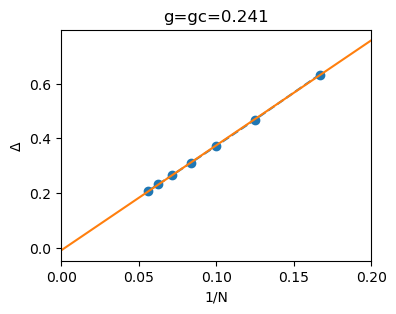

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4fd2966080>

In [83]:
figure(figsize=(4,3))
plot(x, y, "o--")
xlim(0, 0.2)
title("g=gc=0.241")
xlabel("1/N")
ylabel(L"\Delta");

x1 = 0:0.001:0.2
plot(x1, fun(x1, coef(res)))

For g>g_c, here g=0.48.

In [84]:
x = 1 ./ Ns
y = Egs_sz1[:,3]-Egs_sz0[:,3]

fun(x, a) = a[1] .+ a[2]*x .+ a[3]*(x.^2)
res = LsqFit.curve_fit(fun, x, y, [0., 0., 0.])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.1466031964733782, 1.6053601976026983, 3.624143278062775], [0.0005298400198322506, -0.001817305685990478, 0.0006419215530247824, 0.0010159003532577149, 0.0006874611198614544, -4.762251257889316e-5, -0.0010101948474139366], [1.0000000000052196 0.16666666667119912 0.027777777778236822; 1.000000000000636 0.12500000000054418 0.015624999999625848; … ; 1.000000000000636 0.0624999999988445 0.003906249999590279; 1.000000000000636 0.05555555555706637 0.003086419753137425], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

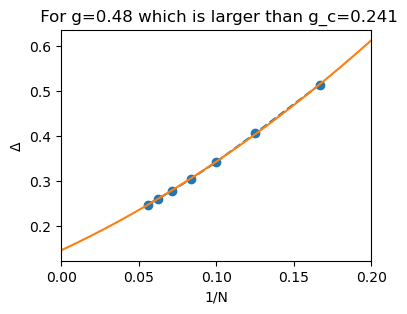

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4fd291fa00>

In [85]:
figure(figsize=(4,3))
plot(x, y, "o--")
xlim(0, 0.2)
title(" For g=0.48 which is larger than g_c=0.241")
xlabel("1/N")
ylabel(L"\Delta");

x1 = 0:0.001:0.2
plot(x1, fun(x1, coef(res)))

# (3)

In [100]:
Ns = 6:2:18
Egs_sz0=zeros(length(Ns),length(J2_arr))
Ees_sz0=zeros(length(Ns),length(J2_arr))

for (i,N) in enumerate(Ns)
    Nup = Int(N/2)
    basis_sz0 = FixedSzBasis(N,Nup);
    for (j,J2) in enumerate(J2_arr)
        @time Heff = generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,basis_sz0)
        res = eigs(Heff; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
        En = sort(res[1])    
        Egs_sz0[i,j] = En[1]
        Ees_sz0[i,j] = En[2]
    end
end

Dimension of subspace with S^z=0.0 is 20
  0.000029 seconds (18 allocations: 6.391 KiB)
  0.000069 seconds (24 allocations: 11.422 KiB)
  0.000050 seconds (24 allocations: 11.422 KiB)
  0.000047 seconds (24 allocations: 11.422 KiB)
  0.000041 seconds (24 allocations: 11.422 KiB)
  0.000107 seconds (24 allocations: 11.422 KiB)
  0.000025 seconds (24 allocations: 11.422 KiB)
Dimension of subspace with S^z=0.0 is 70
  0.000102 seconds (20 allocations: 23.469 KiB)
  0.000113 seconds (28 allocations: 44.562 KiB)
  0.000151 seconds (28 allocations: 44.562 KiB)
  0.000168 seconds (28 allocations: 44.562 KiB)
  0.000134 seconds (28 allocations: 44.562 KiB)
  0.000112 seconds (28 allocations: 44.562 KiB)
  0.000300 seconds (28 allocations: 44.562 KiB)
Dimension of subspace with S^z=0.0 is 252
  0.000373 seconds (22 allocations: 76.391 KiB)
  0.000582 seconds (34 allocations: 209.859 KiB)
  0.000582 seconds (34 allocations: 209.859 KiB)
  0.000677 seconds (34 allocations: 209.859 KiB)
  0.000708

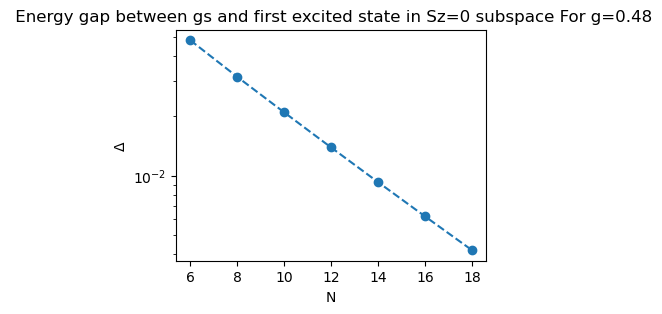

In [99]:
x =  Ns
y = Ees_sz0[:,3]-Egs_sz0[:,3]

figure(figsize=(4,3))
plot(x, y, "o--")

title(" Energy gap between gs and first excited state in Sz=0 subspace For g=0.48")
xlabel("N")
ylabel(L"\Delta");
yscale("log")


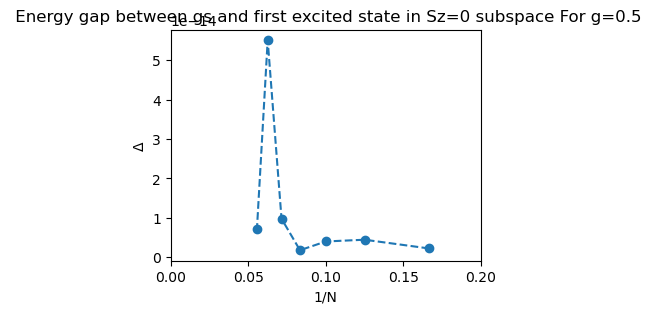

In [93]:
x = 1 ./ Ns
y = Ees_sz0[:,4]-Egs_sz0[:,4]

figure(figsize=(4,3))
plot(x, y, "o--")
xlim(0, 0.2)
title(" Energy gap between gs and first excited state in Sz=0 subspace For g=0.5")
xlabel("1/N")
ylabel(L"\Delta");

We can see that the scale of $\Delta$ is 1e-14, thus effectively zero for all N

# (4)

In [163]:
function Sᶻⱼψ(ψ,basis,j)
    D= length(ψ)
    N_qubits= basis.N
    new_ψ=zeros(D)
    for k in range(1,length=D)
        a = basis.states[k]
        i= (j-1)%N_qubits+1
        sᵢ = ( a & 1<<(i-1) ) >> (i-1)
        new_ψ[k]=ψ[k]*(2*sᵢ-1)
    end
    return new_ψ
end

Sᶻⱼψ (generic function with 2 methods)

In [164]:
function ψS₁S₁₊ₓψ(ψ,basis,x)
    return ψ⋅(Sᶻⱼψ(Sᶻⱼψ(ψ,basis,x+1),basis,1))
end

ψS₁S₁₊ₓψ (generic function with 2 methods)

In [165]:
gc=0.241
g_arr=[0, gc, 0.48 ,1/2, 1, 2, 5]
J1=1
J2_arr=g_arr.*J1
N=18

18

In [166]:
Nup = Int(N/2)
basis_sz0 = FixedSzBasis(N,Nup);
ground_states_arr=Array{Vector{Any}}(undef,length(J2_arr))

Dimension of subspace with S^z=0.0 is 48620


7-element Vector{Vector{Any}}:
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef

In [169]:
for (i,J2) in enumerate(J2_arr)
    @time Heff = generelized_hamiltonian_given_J1_J2_and_fixed_Sz_basis(J1,J2,basis_sz0)
    eigenvalues, eigenvectors = eigs(Heff; nev=1, which=:LM, ritzvec=true) # Using Lanczos to calculate lowest eigenvalues!
    ground_states_arr[i]=eigenvectors[:,1]
end

 10.992268 seconds (41 allocations: 28.488 MiB)
 23.848120 seconds (66 allocations: 46.754 MiB, 0.09% gc time)
 23.369854 seconds (65 allocations: 46.754 MiB)
 23.095561 seconds (65 allocations: 46.754 MiB)
 23.811901 seconds (65 allocations: 46.754 MiB)
 23.367706 seconds (65 allocations: 46.754 MiB, 0.02% gc time)
 23.517292 seconds (65 allocations: 46.754 MiB, 0.02% gc time)


g=0

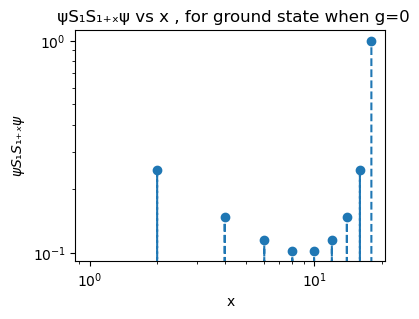

In [214]:
x = range(0,18)
y = [ψS₁S₁₊ₓψ(ground_states_arr[1],basis_sz0,i) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=0")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");
xscale("log")
yscale("log")

g=g_c=0.241

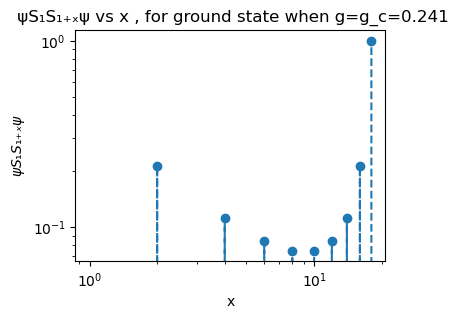

In [213]:
x = range(0,18)
y = [ψS₁S₁₊ₓψ(ground_states_arr[2],basis_sz0,i) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=g_c=0.241")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");
xscale("log")
yscale("log")

g=0.48

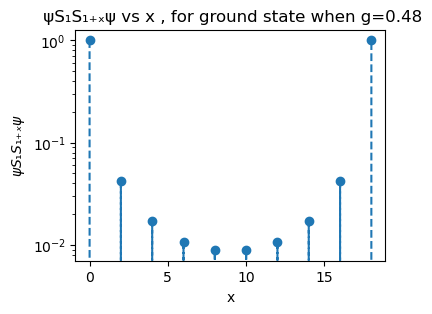

In [212]:
x = range(0,18)
y = [ψS₁S₁₊ₓψ(ground_states_arr[3],basis_sz0,i) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=0.48")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");
yscale("log")

g=0.5

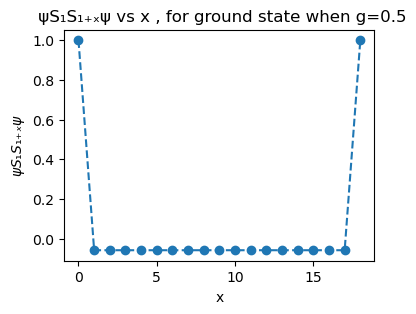

In [211]:
x = range(0,18)
y = [ψS₁S₁₊ₓψ(ground_states_arr[4],basis_sz0,i) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=0.5")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");

g=1

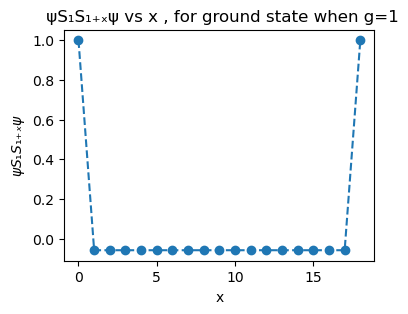

In [210]:
x = range(0,18)
y = [ψS₁S₁₊ₓψ(ground_states_arr[5],basis_sz0,i) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=1")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");

g=2

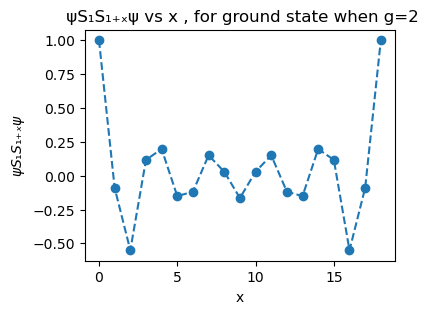

In [209]:
x = range(0,18)
y = [ψS₁S₁₊ₓψ(ground_states_arr[6],basis_sz0,i) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=2")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");

g=5

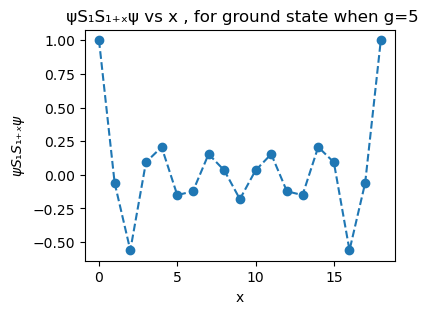

In [208]:
x = range(0,18)
y = [ψS₁S₁₊ₓψ(ground_states_arr[7],basis_sz0,i) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ψS₁S₁₊ₓψ vs x , for ground state when g=5")
xlabel("x")
ylabel(L"ψS₁S₁₊ₓψ");

# (5)

In [187]:
function Bₓ(ψ,basis,x)
    return Sᶻⱼψ(Sᶻⱼψ(ψ,basis,x+1),basis,x)
end

Bₓ (generic function with 1 method)

In [189]:
function B₁Bₓ₊₁(ψ,basis,x)
    return Bₓ(Bₓ(ψ,basis,1+x),basis,1)
end

B₁Bₓ₊₁ (generic function with 1 method)

g=0

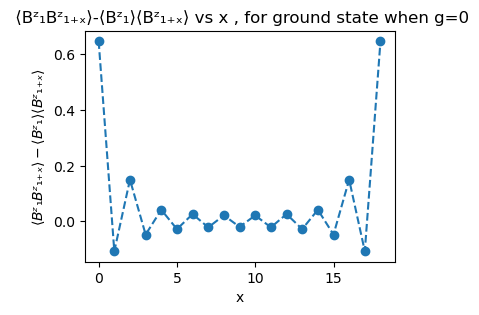

In [207]:
x = range(0,18)
ψ=ground_states_arr[1]
y = [ψ⋅B₁Bₓ₊₁(ψ,basis_sz0,i)- (ψ⋅Bₓ(ψ,basis_sz0,1))*(ψ⋅Bₓ(ψ,basis_sz0,1+i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩ vs x , for ground state when g=0")
xlabel("x")
ylabel(L"⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩");

g=0.241

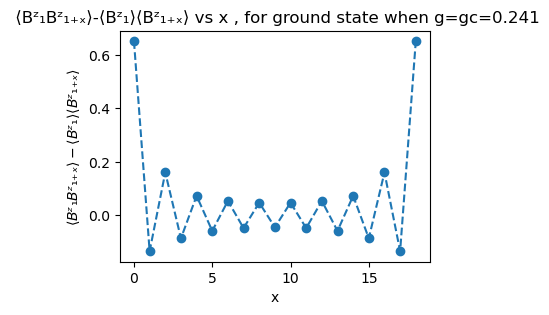

In [205]:
x = range(0,18)
ψ=ground_states_arr[2]
y = [ψ⋅B₁Bₓ₊₁(ψ,basis_sz0,i)- (ψ⋅Bₓ(ψ,basis_sz0,1))*(ψ⋅Bₓ(ψ,basis_sz0,1+i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩ vs x , for ground state when g=gc=0.241")
xlabel("x")
ylabel(L"⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩");

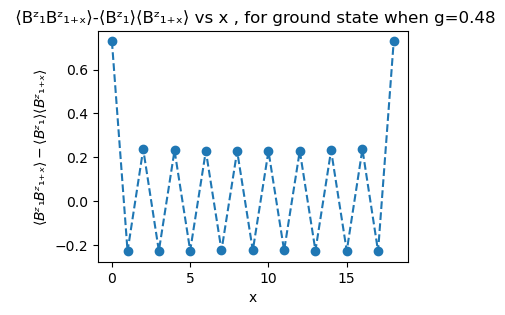

In [204]:
x = range(0,18)
ψ=ground_states_arr[3]
y = [ψ⋅B₁Bₓ₊₁(ψ,basis_sz0,i)- (ψ⋅Bₓ(ψ,basis_sz0,1))*(ψ⋅Bₓ(ψ,basis_sz0,1+i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩ vs x , for ground state when g=0.48")
xlabel("x")
ylabel(L"⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩");

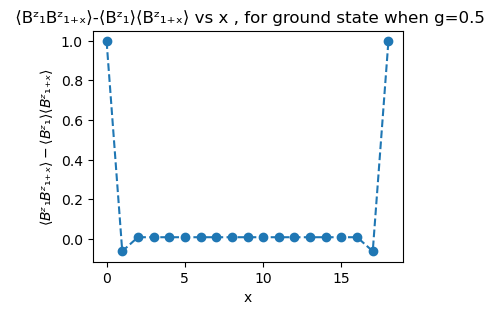

In [203]:
x = range(0,18)
ψ=ground_states_arr[4]
y = [ψ⋅B₁Bₓ₊₁(ψ,basis_sz0,i)- (ψ⋅Bₓ(ψ,basis_sz0,1))*(ψ⋅Bₓ(ψ,basis_sz0,1+i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩ vs x , for ground state when g=0.5")
xlabel("x")
ylabel(L"⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩");

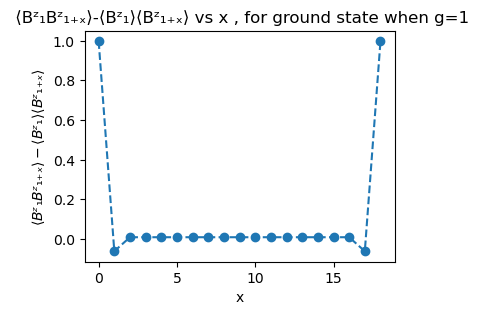

In [202]:
x = range(0,18)
ψ=ground_states_arr[5]
y = [ψ⋅B₁Bₓ₊₁(ψ,basis_sz0,i)- (ψ⋅Bₓ(ψ,basis_sz0,1))*(ψ⋅Bₓ(ψ,basis_sz0,1+i)) for i in x]

figure(figsize=(4,3))
plot(x, y, "o--")
title(" ⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩ vs x , for ground state when g=1")
xlabel("x")
ylabel(L"⟨Bᶻ₁Bᶻ₁₊ₓ⟩-⟨Bᶻ₁⟩⟨Bᶻ₁₊ₓ⟩");